# IMDB Movie Review Sentiment Analysis

## 1. Introduction

IMDB dataset having 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing a set of 25,000 highly polar movie reviews for training and 25,000 for testing.

**Objective** - Predict positive and negative reviews using deep learning algorthms.

For more dataset information, please go through the following link,
[Stanford Link](http://ai.stanford.edu/~amaas/data/sentiment/).



## 2. Import Libraries

In [2]:
pip install emoji --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.2/553.2 kB 5.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import emoji

In [4]:
# Import Keras libraries for LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, GlobalMaxPool1D, Dropout, Input, Dense
from sklearn.metrics import roc_auc_score


In [5]:
# Import Google  Drive
from google.colab import drive

In [6]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
MAX_SEQUENCE_LENGTH = 500
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 20

## 3. Load Dataset

In [8]:
# Path to the dataset
df_path = '/content/drive/MyDrive/Sentiment-Analysis-Movie-Review/IMDB Dataset.csv'
glove_path = '/content/drive/MyDrive/Sentiment-Analysis-Movie-Review/glove.6B.100d.txt'

In [9]:
df = pd.read_csv(df_path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
print(f"This dataset has {df.shape[0]} number of reviews with only 2 columns the review and the sentiment or label to predict")

This dataset has 50000 number of reviews with only 2 columns the review and the sentiment or label to predict


In [11]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


This dataset has the same number of positive and negative reviews so it a well-balanced dataset that will help our Neural Network.

In [12]:
df['review'].isnull().values.any()

False

Dataset does not have NULL values

In [13]:
documents = df['review'].values

In [14]:
print('max documents length:', max(len(d) for d in documents))
print('min documents length:', min(len(d) for d in documents))
d = sorted(len(d) for d in documents)
print('median documents length:', d[len(d) // 2])

max documents length: 13704
min documents length: 32
median documents length: 970


The length of the documents is variable so we need to be careful in order to apply the sequence length to our model



## 4. Data Preprocessing


Create a dictionary of word vectors from glove

In [15]:
embedding_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
    print(f'Found {len(embedding_index)} word vectors.')

Found 400000 word vectors.


In [16]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

Replace Chat words with their respective meaning

In [18]:
# Here Come ChatWords
# Repository Link : https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [19]:
def chat_conversion(text):
    new_text = []
    for i in text.split():
        if i.upper() in chat_words:
            new_text.append(chat_words[i.upper()].lower())
        else:
            new_text.append(i)
    return " ".join(new_text)

In [20]:
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub('<[^<]+?>', '', text)
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    # Remove Emojis
    text = emoji.demojize(text)
    # Convert Chat Words
    text = chat_conversion(text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [21]:
df['review_cleaned'] = df['review'].apply(preprocess_text)
df.head()

,review,sentiment,review_cleaned
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching 1 oz episode h...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend tear eye hot summe...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love tear eye money visually stu...


## 6. Data Splitting

In [22]:
X = df['review_cleaned']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VALIDATION_SPLIT, random_state=42)

In [23]:
# Convert labels to binary
y_train = np.where(y_train == 'positive', 1, 0)
y_test = np.where(y_test == 'positive', 1, 0)

## 7. Tokenization and Padding

In [24]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

In [25]:
word2idx = tokenizer.word_index
print(f'Found {len(word2idx)} unique tokens')

Found 85536 unique tokens


In [26]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## 8. Build LSTM Model

In [27]:
embedding_layer = Embedding(input_dim=MAX_VOCAB_SIZE,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(128,dropout=0.4, recurrent_dropout=0.4, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [29]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 500, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 500, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,125,569 (8.11 MB)

 Trainable params: 125,569 (490.50 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

## 8. Train the Model

In [30]:
history = model.fit(X_train_pad, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test_pad, y_test), verbose=1)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.6537 - loss: 0.6050 - val_accuracy: 0.8227 - val_loss: 0.3960
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.8032 - loss: 0.4300 - val_accuracy: 0.8480 - val_loss: 0.3447
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.8287 - loss: 0.3851 - val_accuracy: 0.8587 - val_loss: 0.3266
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 577s 2s/step - accuracy: 0.8422 - loss: 0.3637 - val_accuracy: 0.8669 - val_loss: 0.3133
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 536s 2s/step - accuracy: 0.8517 - loss: 0.3412 - val_accuracy: 0.8732 - val_loss: 0.2975
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.8537 - loss: 0.3349 - val_accuracy: 0.8760 - val_loss: 0.2895
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - accuracy: 0.8616 - loss: 0.3231 - val_accuracy: 0.8818 - val_loss: 0.2852
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - accuracy: 0.8642 - loss: 0.3149 - val_accu

## 9. Evaluate the Model

313/313 ━━━━━━━━━━━━━━━━━━━━ 88s 281ms/step
Accuracy: 0.8958

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      4961
           1       0.91      0.88      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



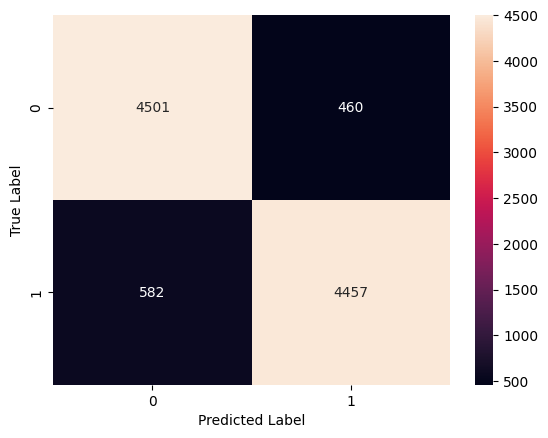

In [31]:
# - Evaluate the model on the test set
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

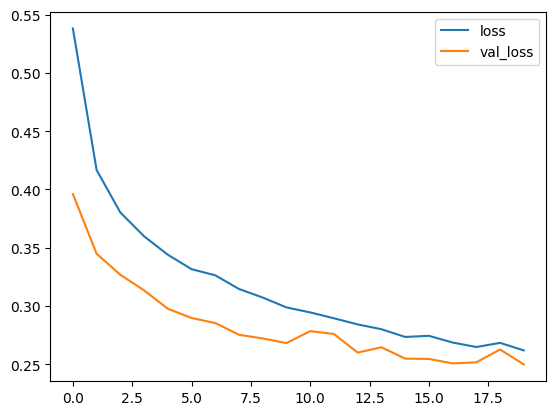

In [32]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

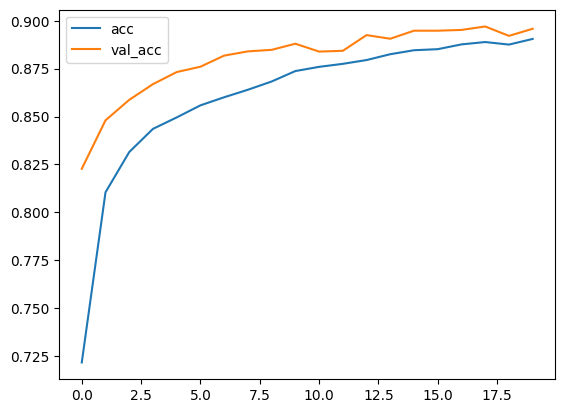

In [33]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

## 10. Analysis and Conclusions

In this project, we developed a sentiment analysis model using an LSTM neural network on the IMDB movie review dataset. By employing pre-trained GloVe word embeddings, we achieved an accuracy of almost 90%, we do not identified significant overfitting throughout training.

- The use of **pre-trained GloVe embeddings** we wanted to provide a strong starting point for word representations.
- **LSTM architecture** allowed the model to capture long-term dependencies and contextual information within movie reviews.
- Regularization techniques like **dropout** helped prevent overfitting.

In future work, hyperparameter tuning (e.g., increasing the embedding dimension, adjusting the learning rate, or using more complex models like Bidirectional LSTMs or Transformers) could improve the performance beyond 90%. Howeverthe current sentiment analysis model can effectively classify the sentiment of IMDB movie reviews with high accuracy.
